In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything
from pathlib import Path
from sklearn.model_selection import train_test_split

seed_everything(42, workers=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

Seed set to 42


cuda
NVIDIA RTX A6000


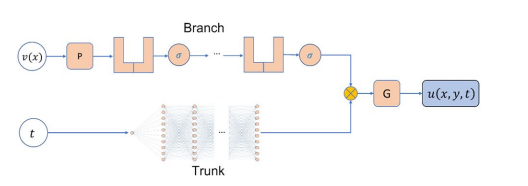

### 1) Dataset Preparation

In [3]:
data_dir = Path("C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset")
for file in data_dir.iterdir():
    print(file)

C:\Users\idris_oduola\Documents\Projects\RqPINN\dataset\dP_test_u.pt
C:\Users\idris_oduola\Documents\Projects\RqPINN\dataset\lite_dataset
C:\Users\idris_oduola\Documents\Projects\RqPINN\dataset\sg_test_u.pt


In [4]:
#We first define the time discretization as explained in the U_FNO paper. 
#To be used in the trunk net here
total_length = 30; step_count = 24; min_step = 1; amp = 1.421245; t_max = 30*365 #365 days in a year
t_steps = np.array([min_step * (amp)**n for n in range(step_count)])
t_sum = np.sum(t_steps) # Should be approximately t_max
t_normalized = t_steps * (t_max/t_sum) #We need to normalize to fit the total time span of 30 years
t_grid = torch.tensor(np.cumsum(t_normalized)).view(-1,1) #The cummulative time points
print(f"t_grid shape: {t_grid.shape}")

t_grid shape: torch.Size([24, 1])


In [7]:
class config:
    def __init__(self, t_grid):
        #The File paths
        self.data_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/dP_test_u.pt' #The unnormalized pressure build-up data
        self.model_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/udeeponet_model.pt'
        self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/checkpoint_udeeponet'

        #Trunk Net parameter
        self.time_dim = 24
        self.base_channel = 96
        self.hidden_dim = 128
        self.layers = 10
        self.t_grid = t_grid
        
        
        #Optimizer
        self.lr = 0.0006
        self.weight_decay = 1e-4 #Regularization weight
        
        #The training parameters
        self.num_epoch = 100
        self.batch_size = 20

        #Learning rate scheduler
        self.step_size = 20  #To decay after every, say 10 epochs
        self.gamma = 0.5      #To reduce the learning rate by gamma (say, 1/2)

        

cfg = config(t_grid)

In [8]:
#first, lets try to visualize our data
data_vis = torch.load(cfg.data_path, weights_only = "True")
print(data_vis.shape)

torch.Size([500, 96, 200, 24])


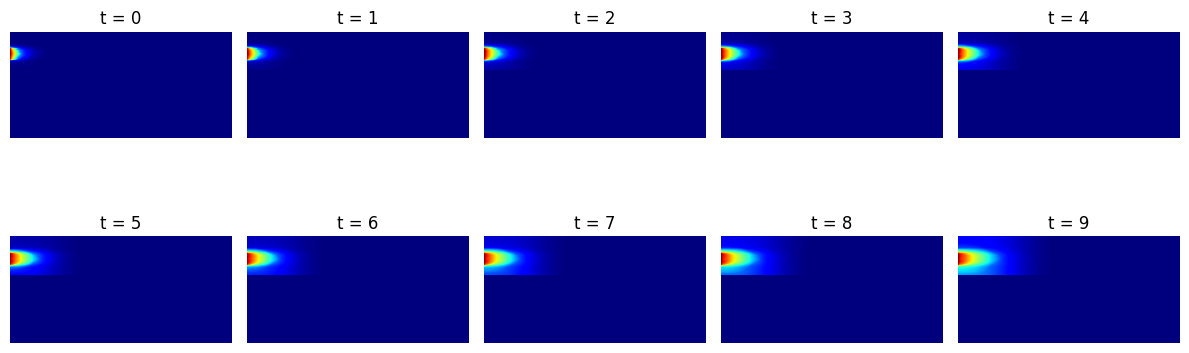

In [9]:
data0 = data_vis[200]
plt.figure(figsize = (12,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(f"t = {i}")
    plt.imshow(data0[:,:,i], cmap ='jet')
    plt.axis("off")
plt.tight_layout()
plt.show()


> In the paper it is the input data is of shape (n, 96, 200, 24, 12) where the last dimension are seen as channels consisting of input variables (4 field variables and 5 scalar variables) + extra channels most likely spatial coordinate, to provide positional information and enable generalization across grids. 
In this notebook, our dataset is of shape (n,96,200,24). As a simplification of the model, we will only include some scalar variables and the spatial coordinate channels. The whole field and scalar variables can always be obtained as provided in the U-FNO paper by Wen et al.


In [10]:
def input_variables(data):
    B, H, W, T = data.shape
    #1) Injection rate Q
    Q_channel = np.full((H,W), np.random.uniform(0.2,2.0)) #(96,200)
    #2) Initial Pressure
    P_channel = np.full((H,W), np.random.uniform(100, 300)) #(96,200)
    #3) The Spatial coordinates
    x_coords = torch.linspace(0,1, steps = W).view(1,-1).expand(H,W)
    y_coords = torch.linspace(0,1, steps = H).view(-1,1).expand(H,W)
    #Stacking the input variables
    scalar_stack = torch.tensor(np.stack([Q_channel, P_channel, x_coords, y_coords], axis = -1)).float() #(96,200,4)
    scalar_stack = scalar_stack.unsqueeze(0).unsqueeze(3) #(1,96,200,1,4)
    scalar_stack = scalar_stack.repeat(B,1,1,T,1) #(B,96,200,T,4)
    #Concatenating with the dataset
    data1 = data.unsqueeze(-1) #(C,96,200,T,1)
    new_data = torch.cat([data1,scalar_stack], dim = -1) #(B,96,200,T,5)
    assert new_data.shape[-1] == 5, print(f"Loaded input variables successfully. Data now has size {new_data.shape}")
    return new_data

In [11]:
def prepare_data(data,cfg):
    data = torch.load(cfg.data_path,  weights_only=True) #Loading the data set
    
    #First, we generate the some of the scalar and field variables as channels to our data
    new_data = input_variables(data)
    

    #The Branch Net
    branch_input = new_data[:,:,:,0,:] #CO2 storage of the first day, so DeepONet can predict over the next days leading to 30 years
    print(f"Branch input Shape:{branch_input.shape}")

    #Train, test and validation split
    # First we split 500-> 400 train, 100 shared for test and val
    X_train, X_temp, Y_train, Y_temp = train_test_split(
        branch_input, data, test_size = 100, random_state = 42, shuffle = True
    )
    print(f"After split --> Branch_train: {X_train.shape} ----- Target: {Y_train.shape}")
    #Next we split 100 -> 50 val, 50 test
    X_val, X_test, Y_val, Y_test = train_test_split(
        X_temp, Y_temp, test_size = 0.5, random_state = 42, shuffle = True
    )
    
    print(f"After split --> Branch_test: {X_test.shape} ----- Target: {Y_test.shape}")
    #creating the dataloader
    train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size = cfg.batch_size, shuffle = True)
    test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size = cfg.batch_size, shuffle = False)
    val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size = cfg.batch_size, shuffle = False, num_workers = 3)

    return train_loader, test_loader, val_loader

In [13]:
class DataModule(pl.LightningDataModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
        self.t_grid = None

    def setup(self, stage = None):
        pressure_data = torch.load(self.cfg.data_path, weights_only = "True")
        self.train_loader, self.test_loader, self.val_loader= prepare_data(pressure_data,self.cfg)
        print('DataLoaded Successfully')

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader

data_module = DataModule(cfg)
        

In [14]:
data_module.setup()

Branch input Shape:torch.Size([500, 96, 200, 5])
After split --> Branch_train: torch.Size([400, 96, 200, 5]) ----- Target: torch.Size([400, 96, 200, 24])
After split --> Branch_test: torch.Size([50, 96, 200, 5]) ----- Target: torch.Size([50, 96, 200, 24])
DataLoaded Successfully


## 2) U-DeepONet

#### 2.1) UNet

> **Note**:The channel of our data is in the last dimension, so we have to reshape before passing in the UNet.

We are going the follow the UNet structure in the paper, which I have pasted below

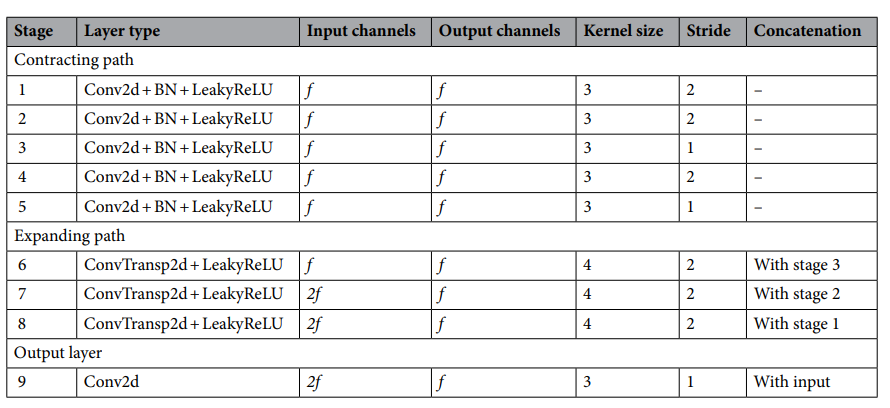

In [15]:
#We will be defining the convolutional block
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        """
        conv --> batchnorm --> LeakyReLU
        """
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace = True)
        )
    
    def forward(self,x):
        return self.block(x)

In [16]:
#Now we define the downsampling and upsampling layer in the UNet.
#the Downsampling here are done using appropriate strides and padding
class up_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2),
            nn.LeakyReLU(inplace = True)
        )
        

    def forward(self, x1, x2): #x2 is the skip connection from the encoder
        x1 = self.up(x1)
        
        #We need to add paddings to match x2 if needed
        y_diff = x2.size()[2] - x1.size()[2]
        x_diff = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [x_diff//2, x_diff - x_diff//2, y_diff//2, y_diff - y_diff//2])
        x = torch.cat([x1,x2], dim = 1)
        
        return x

#Finally the output convolution layer
class out_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x1, x2):
        x1 = self.conv1(x1) #This reduces the channels coming from the decoder from 2f --> f
        #We need to add paddings to match x2 if needed
        y_diff = x2.size()[2] - x1.size()[2]
        x_diff = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [x_diff//2, x_diff - x_diff//2, y_diff//2, y_diff - y_diff//2])
        x = torch.cat([x1,x2], dim = 1)
        return self.conv2(x)  # keeps spatial dims intact

In [17]:
class UNet(nn.Module):
    def __init__(self, base_channel = 96):
        super().__init__()
        #The Encoder block (There are 5 blocks in the encoder block)
        self.encoder_block = nn.ModuleList()
        for i in range(5):
            if i == 2 or i == 4:
                self.encoder_block.append(conv_block(base_channel, base_channel, stride = 1))

            else:
                self.encoder_block.append(conv_block(base_channel, base_channel, stride = 2))

        #There is no bottleneck or connection in this UNet
    
        #The decoder block (There are 3 blocks here)
        self.decoder_block = nn.ModuleList()
        for i in range(3):
            if i == 0:
                self.decoder_block.append(up_layer(base_channel, base_channel))
            else:
                self.decoder_block.append(up_layer(2*base_channel, base_channel))
    
        #The final output convolution
        self.final_conv = out_conv(2*base_channel, base_channel)
        self.activation = nn.LeakyReLU(inplace = True)

    def forward(self, x):
        res = []
        res.append(x)
    
        for i, down in enumerate(self.encoder_block):
            x = down(x)
            if i < 3:
                res.append(x)
    
        for i, up in enumerate(self.decoder_block):
            x2 = res.pop()
            x = up(x, x2)
        x3 = res.pop()
        x = self.final_conv(x,x3)
        return self.activation(x)

#### DeepONet
> We also follow the same structure as outlined in the paper, but recall that the initial input channel for this notebook has been reduced

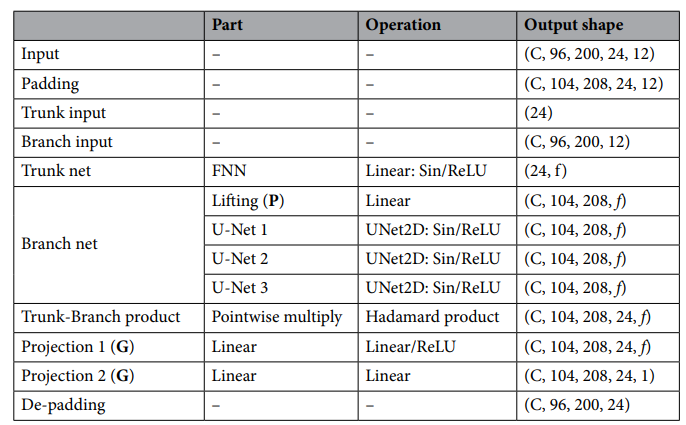


In [18]:
#first we define the branch net
class branch_net(nn.Module):
    def __init__(self, base_channel =96):
        super().__init__()
        self.pad = nn.ConstantPad2d((4,4,4,4),0) #padding the input
        self.lift = nn.Conv2d(in_channels = 5, out_channels = base_channel, kernel_size = 1) #The Lift layer
        self.unets = nn.ModuleList([UNet(base_channel) for _ in range(3)])

    def forward(self,x):
        assert x.shape[1:] == (96,200,5), f"Unexpected input shape: {x.shape}"
        x = x.permute(0,3,1,2) #Move the channels to have (batch, 5, 96,200)
        x = self.pad(x) #add the paddings --> (batch, 5, 104,208)
        x = self.lift(x) #Linear lifting layer --> (batch, f, 104,208)
        #The UNet
        for unet in self.unets: #Three UNets in the branch net
            x = unet(x)

        x = x.permute(0,2,3,1) # reorder for DeepOnet Hadamard product --> (batch, 104, 208, f)
        return x

#Now we define the Trunk net
class trunk_net(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.activation = nn.ReLU()
        self.base_channel = cfg.base_channel
        self.hidden_dim = cfg.hidden_dim
        self.layers = cfg.layers

        #Defining the layers
        self.linears = nn.ModuleList()

        self.linears.append(nn.Linear(1, self.hidden_dim))
        for _ in range(self.layers - 2):
            self.linears.append(nn.Linear(self.hidden_dim, self.hidden_dim))
        self.linears.append(nn.Linear(self.hidden_dim, self.base_channel)) #Output is (24,96)

    def forward(self,t):
        a = t.float()
        for linear in self.linears[:-1]:
            a = self.activation(linear(a))
        return self.linears[-1](a)

In [19]:
class DeepONet(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.branch = branch_net(cfg.base_channel)
        self.trunk = trunk_net(cfg)
        self.proj1 = nn.Linear(cfg.base_channel, cfg.base_channel) #f -> f
        self.proj2 = nn.Linear(cfg.base_channel, 1) #f -> 1
        self.cfg = cfg

    def forward(self,x):
        """
        x: shape (batch, 96,200, 5)
        t: shape (24,1)

        output: (batch, 96, 200, 24)
        """
        t = self.cfg.t_grid.to(x.device)

        B = x.shape[0]
        T = t.shape[0]
        f = self.cfg.base_channel
        #The branch net: (batch, 96, 200, 5) --> (batch, 104, 208, f)
        B_out = self.branch(x) 

        #The Trunk net: (24,1) --> (24,f)
        T_out = self.trunk(t) 

        #The Hadamard product (Not that Hadamard product is used here rather than the inner product known to be used for vanilla DeepONet)
        #Then a projection layer is used to reduce the dimension
        #But first we expand the Trunk and Branch to match each other's shape
        T_out = T_out.view(1,1,1,T,f)   #(1,1,1,24,f)
        B_out = B_out.unsqueeze(3)    #(batch, 104,108, 1, f)
        hadamard = T_out * B_out      #(batch, 104,108,24,f)

        #Finally, the projection layers
        output = self.proj1(hadamard)   #(batch, 104,108,24,f) --> (batch, 104,108,24,f)
        output = F.relu(output)
        output  = self.proj2(output).squeeze(-1)   #(batch, 104,108,24,f) --> (batch, 104,108,24)

        #Depadding
        output = output[:, 4:-4, 4:-4, :]   # lets just crop them out: (batch, 104,108,24) --> (batch, 96,200,24)

        return output
        

## 3) Training
We first define a simple mask function that helps us in the loss computation. This is because it is said in the U-FNO paper:
> *our data set contains reservoirs with various thicknesses and the cells outside of the reservoir are padded with zeros for both input and output. To accommodate for the variable reservoir thicknesses, during training, we construct an active cell mask for each data sample and only calculate the loss within the mask. Our experiments show that this loss calculation scheme achieves better performance than calculating the whole field because of the better gradient distribution efficiency.*

Also, the loss is defined as:

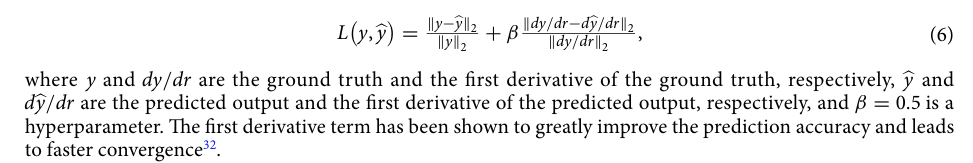

> We will compute this derivative using the central difference method along the width.

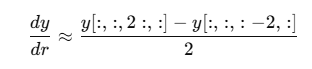

In [20]:
def mask_function(images, threshold = 1e-5):
    # images: (C, H, W, T)
    C, H, W, T = images.shape
    # Create mask where the data is not all-zero across time and space
    mask = (torch.amax(torch.abs(images), dim=(2, 3)) > threshold).int()
    # Reshape to (C, H, 1, 1) → broadcast to (C, H, W, T)
    mask = mask.view(C, H, 1, 1).repeat(1, 1, W, T)
    return mask


masks = mask_function(data_vis)
masks.shape

torch.Size([500, 96, 200, 24])

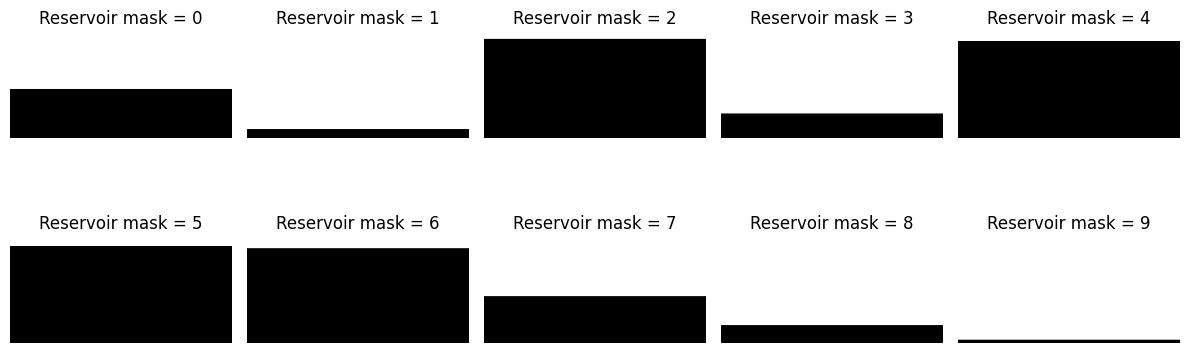

In [21]:
#Lets visualize the first 10 masks
plt.figure(figsize = (12,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(f"Reservoir mask = {i}")
    plt.imshow(masks[i,:,:,0], cmap ='gray')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [25]:
class PlModel(pl.LightningModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.model = DeepONet(cfg)
        self.metrics = {'train_loss':[], 'val_loss':[]}
        

    def forward(self,x):
        return self.model(x)

    def loss_function(self,y_true,y_hat, beta = 0.5):
        lp_norm = lambda x: torch.norm(x, p=2)
        mask = mask_function(y_true)
        #Masking the true ground truth is completely unnecessary, since the paddings are already zero
        y_hat_loss = mask*y_hat #Masking the predictions (Very important!!)
        assert y_hat_loss.shape == y_true.shape, f"Shape Mismatch! prediction shape:{y_hat_loss.shape}, target shape: {y_true.shape}"
        #The value loss
        val_loss = lp_norm(y_true - y_hat_loss) / (lp_norm(y_true)+1e-6) #To avoid division by zero)

        # Derivative loss along r-direction (width = dim 2)
        dy_true = (y_true[:, :, 2:, :] - y_true[:, :, :-2, :])/2
        dy_mask = mask_function(dy_true)
        dy_hat = dy_mask*((y_hat[:, :, 2:, :] - y_hat[:, :, :-2, :])/2)
        deriv_loss = lp_norm(dy_hat - dy_true) / (lp_norm(dy_true) + 1e-6)
    
        return val_loss + beta * deriv_loss
        
    def _common_step(self, batch):
        x,y = batch
        y_hat = self(x)
        assert y_hat.shape == y.shape, f"Shape Mismatch! prediction shape:{y_hat.shape}, target shape: {y.shape}"
        loss = self.loss_function(y,y_hat, beta = 0.5)
        return loss

    def training_step(self, batch):
        loss = self._common_step(batch)
        self.log('train_loss', loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['train_loss'].append(loss.item())
        return loss

    def validation_step(self, batch):
        loss = self._common_step(batch)
        self.log('val_loss', loss, on_step =True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['val_loss'].append(loss.item())
        return loss

    def predict_step(self, batch,batch_idx):
        x,y = batch
        pred = self(x) #or self.model(x)
        return pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.cfg.lr, weight_decay = self.cfg.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = self.cfg.step_size, gamma = self.cfg.gamma)
        return [optimizer], [scheduler]
    

    def evaluate_on_test_set(self, loader):
        self.eval()
        losses = []; predictions = []; targets = []

        with torch.no_grad():
            for batch in loader:
                x, y = batch
                x = x.to(self.device)
                y = y.to(self.device)
                y_hat = self(x)
                predictions.append(y_hat.cpu())
                targets.append(y.cpu())

                assert y_hat.shape == y.shape, f"Prediction shape {y_hat.shape}, target shape {y.shape}"

                loss = self.loss_function(y,y_hat, beta = 0.5)
                losses.append(loss.item())

        avg_loss = sum(losses) / len(losses)
        print(f"Average Loss on exact test set: {avg_loss:.4f}")
        return avg_loss, predictions, targets        

In [23]:
#Training the model
model = PlModel(cfg)

checkpoint_callback = ModelCheckpoint(
    monitor = 'val_loss',
    dirpath = cfg.checkpoint_dir,
    filename = 'udeeponet-{epoch:02d}-{val_loss:.2f}',
    save_top_k = 1,
    mode = 'min',
    save_weights_only = True
)

trainer = pl.Trainer(
    max_epochs = cfg.num_epoch,
    callbacks = [checkpoint_callback],
    accelerator = 'gpu',
    devices = 1,
    enable_progress_bar = True,
    log_every_n_steps = 5,
    deterministic = True
)

#Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Branch input Shape:torch.Size([500, 96, 200, 5])
After split --> Branch_train: torch.Size([400, 96, 200, 5]) ----- Target: torch.Size([400, 96, 200, 24])
After split --> Branch_test: torch.Size([50, 96, 200, 5]) ----- Target: torch.Size([50, 96, 200, 24])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | DeepONet | 4.6 M  | train
-------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.447    Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode


DataLoaded Successfully


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


## 4) Evaluation

In [26]:
#First load best model with validation in checkpoint
checkpoint_path = sorted(Path(cfg.checkpoint_dir).glob("udeeponet-*.ckpt"))[-1]
model = PlModel.load_from_checkpoint(
    checkpoint_path,
    cfg=cfg 
)

pred_loader = data_module.test_dataloader()
predictions = trainer.predict(model, dataloaders=pred_loader)

Branch input Shape:torch.Size([500, 96, 200, 5])
After split --> Branch_train: torch.Size([400, 96, 200, 5]) ----- Target: torch.Size([400, 96, 200, 24])
After split --> Branch_test: torch.Size([50, 96, 200, 5]) ----- Target: torch.Size([50, 96, 200, 24])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


DataLoaded Successfully


c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

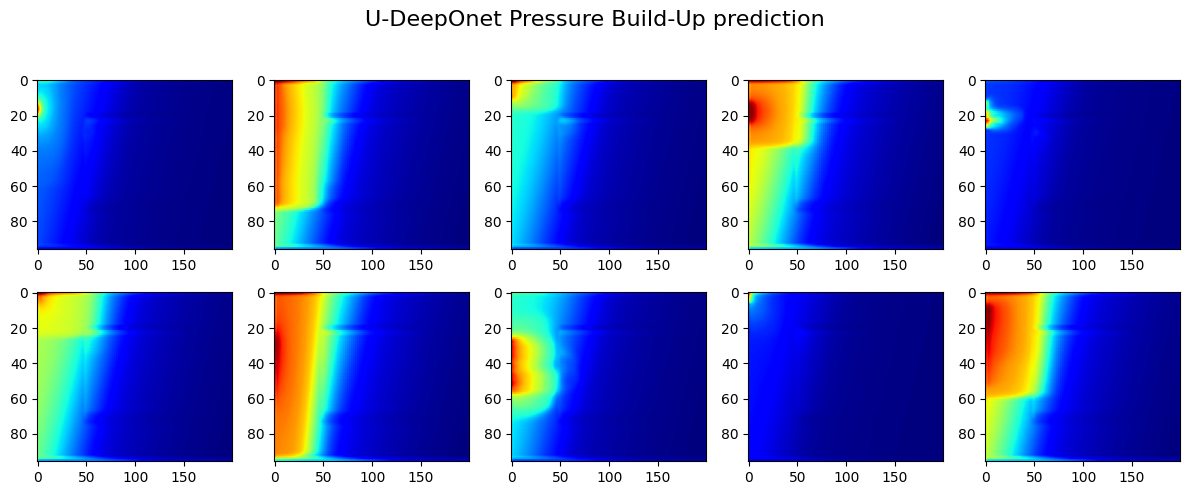

In [ ]:
#Plotting the model prediction after 30 years
plt.figure(figsize=(12, 5))
plt.suptitle("U-DeepOnet Pressure Build-Up prediction", fontsize=16)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(predictions[0][i,:,:,23].squeeze(), cmap='jet', aspect='auto')
    plt.axis("on")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # prevent suptitle from overlapping
plt.show()


In [43]:
model = PlModel.load_from_checkpoint(checkpoint_path, cfg=cfg)
avgloss, preds, exact = model.evaluate_on_test_set(data_module.test_dataloader())

Average Loss on exact test set: 1.1821


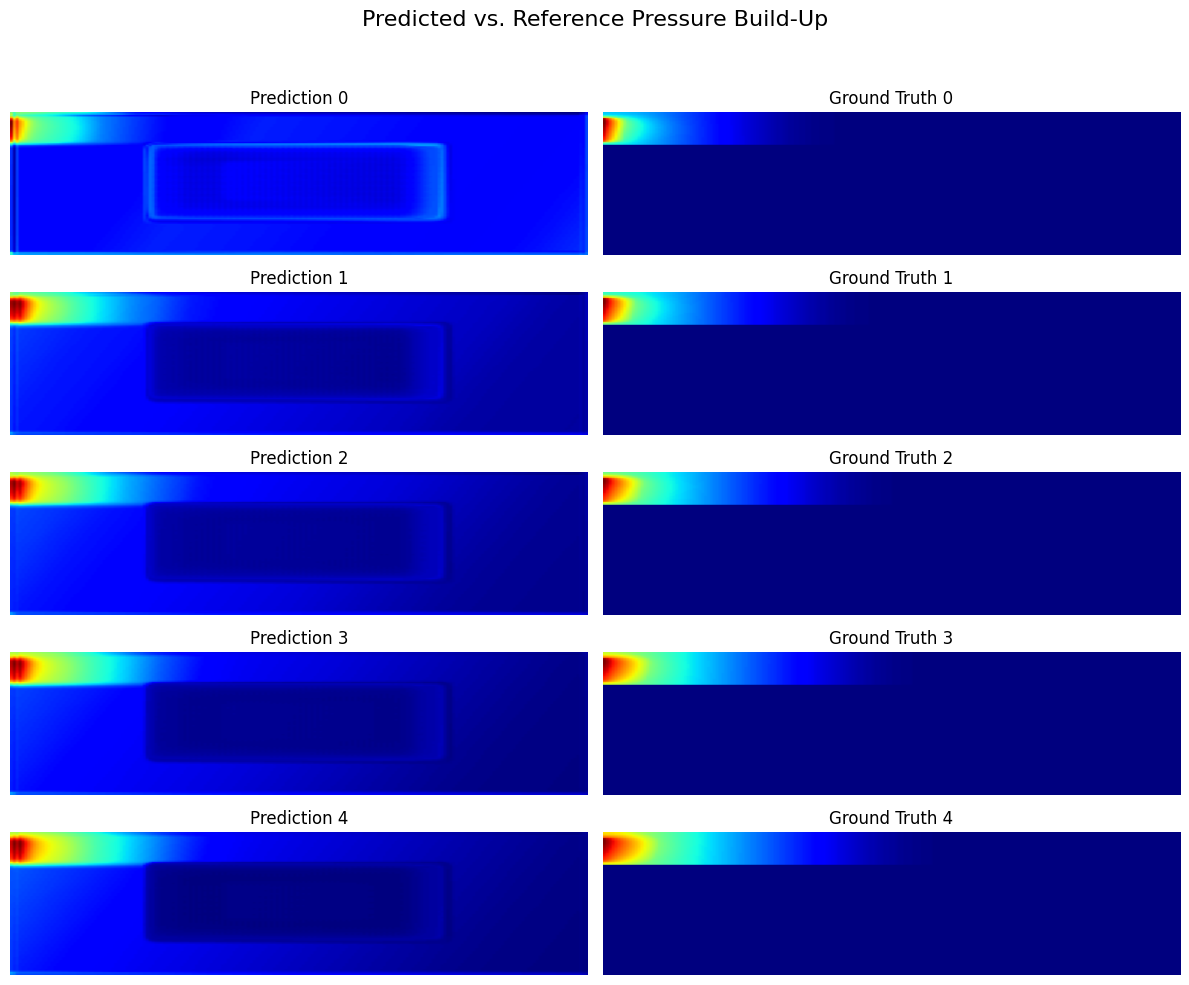

In [51]:
plt.figure(figsize=(12, 10))
plt.suptitle("Predicted vs. Reference Pressure Build-Up", fontsize=16)

n = 10
for i in range(5):  # Plot 5 samples: pred + target
    # Plot prediction
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(preds[0][n,:,:,i].cpu().numpy(), cmap='jet', aspect='auto')
    plt.title(f"Prediction {i}")
    plt.axis("off")

    # Plot corresponding ground truth
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(exact[0][n,:,:,i], cmap='jet', aspect='auto')
    plt.title(f"Ground Truth {i}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
